In [137]:
# load the sentence-bert model from the HuggingFace model hub
#!pip install transformers
import matplotlib.pyplot as plt

In [138]:
from transformers import AutoTokenizer, AutoModel
from torch.nn import functional as F
import numpy as np
tokenizer = AutoTokenizer.from_pretrained('deepset/sentence_bert')
model = AutoModel.from_pretrained('deepset/sentence_bert')

Some weights of the model checkpoint at deepset/sentence_bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [243]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [244]:
# it takes input as a json of sentences and a list of labels as [<list of keywords for label 1>, <>, ..]
# it ouputs a list of encoding objects -> {
#             "sentence": sentence,
#             "encodings": {
#                 "label": label,
#                 "sentence_rep":sentence_rep,
#                 "label_reps":label_reps
#             }}

def BERTencoding(sentences,labels):
    sentence_net = []
    for sentence, labelled_class in sentences.items():
        encodings =[]
        for label in labels:
            # run inputs through model and mean-pool over the sequence
            # dimension to get sequence-level representations
            inputs = tokenizer.batch_encode_plus([sentence] + label,
                                                 return_tensors='pt',
                                                 pad_to_max_length=True)
            input_ids = inputs['input_ids']
            attention_mask = inputs['attention_mask']
            output = model(input_ids, attention_mask=attention_mask)[0]
            sentence_rep = output[:1].mean(dim=1)
            label_reps = output[1:].mean(dim=1)
            
            encodings.append({
                "label": label,
                "sentence_rep":sentence_rep,
                "label_reps":label_reps
            })

        #binding to the output
        sentence_net.append({
            "sentence": sentence,
            "encodings": encodings
            })
    return sentence_net

In [272]:
# takes input the json of the output of BERTencoding list of objects and threshold -> cutoff similarity for a class
# Outputs the list of predictions
def cosineSimilarity(sentence_net, threshold):
    predictions =[]
    for sentence in sentence_net:
        print("----------Sentence similarity for : ",sentence["sentence"])
        labels_similarity = []
        for encoding in sentence["encodings"]:
            label = encoding["label"]
            print("--- Class labels : ", label)
            # now find the labels with the highest cosine similarities to
            # the sentence
            similarities = F.cosine_similarity(encoding["sentence_rep"], encoding["label_reps"])
            closest = similarities.argsort(descending=True)
            similarity_list = []
            for ind in closest:
                print(f'label: {label[ind]} \t similarity: {similarities[ind]}')
                similarity_list.append(float(similarities[ind]))

            # plotting the graph to show similarity with all the labels
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.bar(label,similarity_list)
            plt.show()

            # getting the mean similarity for each label
            print("Mean similarity :", np.mean(similarity_list))
            labels_similarity.append(np.mean(similarity_list))    
            print("\n")

        # getting the predicted class
        print(labels_similarity)
        predicted_labels = [1 if (y>threshold and y==max(labels_similarity))else 0 for y in labels_similarity]
        if 1 in predicted_labels:
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)

        # append the predicted class to the prediction list
        predictions.append(predicted_labels.index(1)+1)
        print("Predicted class : ", predicted_labels.index(1)+1)
        print("------------------------------------------------------")
    return predictions

In [273]:
# takes list of predictions and labels
def evaluation(class_labels, predictions):
    labels = [1,2,3,4] 
    print(classification_report(class_labels, predictions, labels=[1,2,3,4])) #classification report from sklearn
    cnf_matrix = confusion_matrix(class_labels, predictions, labels=labels)
    plt.imshow(cnf_matrix, cmap=plt.cm.Blues) #plot confusion matrix grid
    threshold = cnf_matrix.max() / 2 #threshold to define text color
    for i in range(cnf_matrix.shape[0]): #print text in grid
        for j in range(cnf_matrix.shape[1]): 
            plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
    tick_marks = np.arange(len(labels)) #define labeling spacing based on number of classes
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()

# Revenue Question

In [274]:
sentences = {'Annual recurring revenue':4, 
             'paying members':2,
             'Total income':4,
             'Margins':4,
             'Monthly recurring revenue':4,
             'Total revenue':4,
             'Recurring revenue':4,
             'Profits':4,
             'average expenditure per user':1,
             'revenue per user':1,
             'average monthly revenue from each user':1,
             'number of new subscribers per month':2,
             'estimated initial customers':2,
             'number of new paying members':2,
             'average customer retention':3,
             'projected users subscription length':3
            }
label1 = ['Monthly fee','Fee per user','Charge','Cost','Average revenue per user','Recurring monthly fee','Fee charged per user','Monthly service charge','User fee','Monthly subscription fee']
label2 = ['users','Subscribers','Customers','clients','patrons','payees','members']
label3 = ['Average lifetime','lifespan','Duration subscription','Churn','Attrition','churn rate','Churn analysis','Churn prediction','Churn prevention','Reducing churn','Increasing retention','retention rate','Customer attrition rate','Attrition analysis','Attrition prediction','Attrition prevention']

In [275]:
labels = [label1, label2, label3]
class_labels = []
for key, value in sentences.items():
    class_labels.append(value)

In [276]:
sentence_net = BERTencoding(sentences,labels)

/opt/homebrew/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


----------Sentence similarity for :  questions are easily understandable
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: easy understand 	 similarity: 0.6703381538391113
label: easy direct 	 similarity: 0.6420934200286865
label: easy straightforward 	 similarity: 0.5611382126808167
label: clear 	 similarity: 0.4958990216255188
label: succinct 	 similarity: 0.45353469252586365
label: short 	 similarity: 0.18743547797203064
label: Avoid too long 	 similarity: 0.04380325227975845


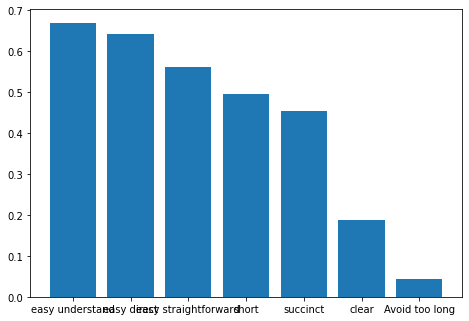

Mean similarity : 0.436320318707398


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: open ended 	 similarity: 0.17659004032611847
label: Do not ask closed 	 similarity: 0.10489607602357864
label: Don't ask directly 	 similarity: 0.09543244540691376
label: Do not ask leading 	 similarity: 0.08675151318311691
label: Avoid suggest answer you want 	 similarity: 0.04967650771141052
label: Do not ask yes/no 	 similarity: -0.017100602388381958


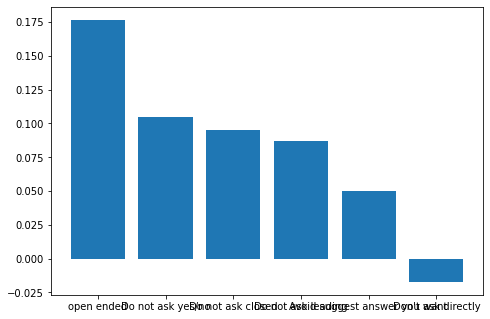

Mean similarity : 0.08270766337712605


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: logical structure 	 similarity: 0.5112177729606628
label: Start easier to relax 	 similarity: 0.42492181062698364
label: Warm up before detailed 	 similarity: 0.3166806995868683
label: sequenced natural way 	 similarity: 0.300115168094635
label: flow one to other 	 similarity: 0.22237913310527802
label: Prepare beforehand 	 similarity: 0.16873590648174286


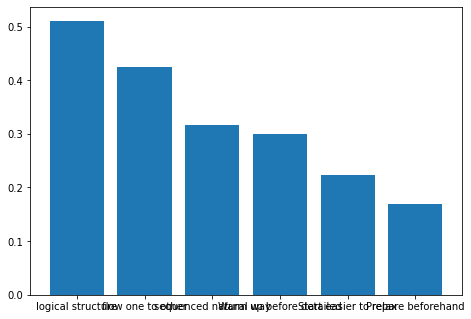

Mean similarity : 0.3240084151426951


[0.436320318707398, 0.08270766337712605, 0.3240084151426951]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  questions are not closed 
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: clear 	 similarity: 0.4633898437023163
label: easy understand 	 similarity: 0.4106239378452301
label: easy direct 	 similarity: 0.4016709327697754
label: easy straightforward 	 similarity: 0.3863743543624878
label: succinct 	 similarity: 0.35172009468078613
label: short 	 similarity: 0.17287582159042358
label: Avoid too long 	 similarity: 0.16260018944740295


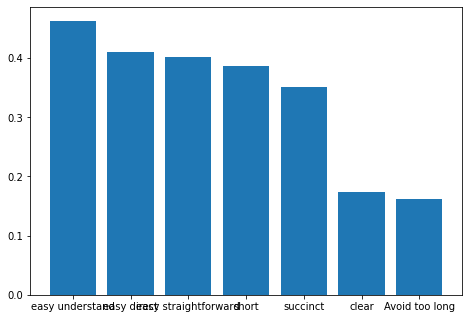

Mean similarity : 0.33560788205691744


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: Do not ask closed 	 similarity: 0.6720290780067444
label: Do not ask leading 	 similarity: 0.4705021381378174
label: Don't ask directly 	 similarity: 0.4613420069217682
label: Do not ask yes/no 	 similarity: 0.32136744260787964
label: Avoid suggest answer you want 	 similarity: 0.30181363224983215
label: open ended 	 similarity: 0.27715542912483215


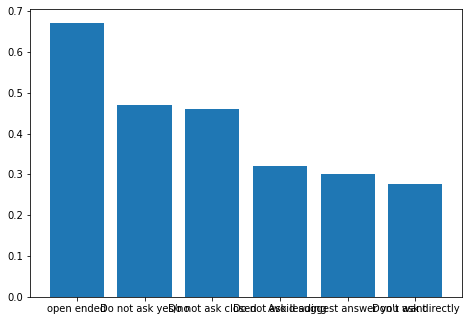

Mean similarity : 0.417368287841479


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: logical structure 	 similarity: 0.3790018558502197
label: flow one to other 	 similarity: 0.3375738263130188
label: Warm up before detailed 	 similarity: 0.26810234785079956
label: Start easier to relax 	 similarity: 0.2493179887533188
label: sequenced natural way 	 similarity: 0.2157585322856903
label: Prepare beforehand 	 similarity: 0.18410031497478485


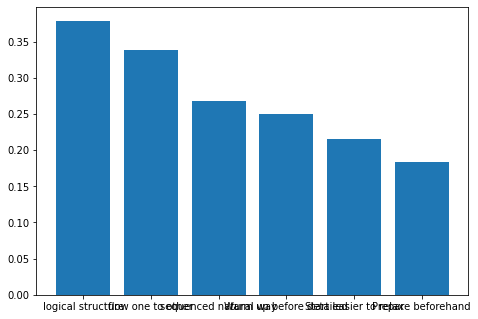

Mean similarity : 0.272309144337972


[0.33560788205691744, 0.417368287841479, 0.272309144337972]
Predicted class :  2
------------------------------------------------------
----------Sentence similarity for :  questions are open to interpretation
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: easy direct 	 similarity: 0.4465622901916504
label: clear 	 similarity: 0.4328763782978058
label: easy understand 	 similarity: 0.431896448135376
label: succinct 	 similarity: 0.4149993062019348
label: easy straightforward 	 similarity: 0.33575162291526794
label: short 	 similarity: 0.14835742115974426
label: Avoid too long 	 similarity: 0.1031683087348938


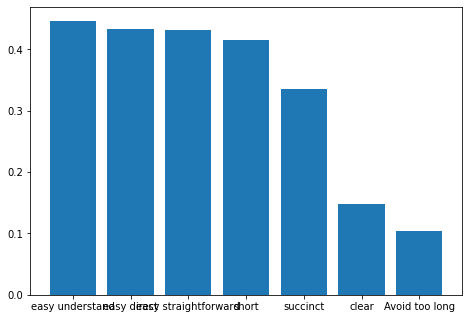

Mean similarity : 0.3305159679480961


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: open ended 	 similarity: 0.34054431319236755
label: Do not ask closed 	 similarity: 0.2575043737888336
label: Avoid suggest answer you want 	 similarity: 0.24897310137748718
label: Don't ask directly 	 similarity: 0.24801908433437347
label: Do not ask leading 	 similarity: 0.2134089469909668
label: Do not ask yes/no 	 similarity: 0.14593814313411713


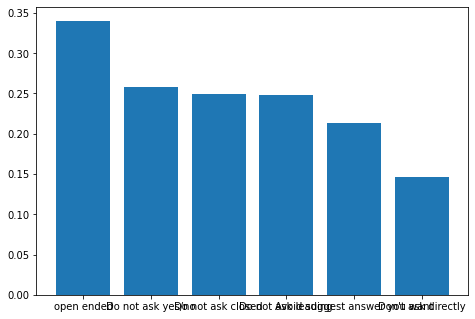

Mean similarity : 0.2423979938030243


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: logical structure 	 similarity: 0.4230130612850189
label: sequenced natural way 	 similarity: 0.31824931502342224
label: flow one to other 	 similarity: 0.3056386411190033
label: Warm up before detailed 	 similarity: 0.2950313091278076
label: Start easier to relax 	 similarity: 0.2592749297618866
label: Prepare beforehand 	 similarity: 0.25036337971687317


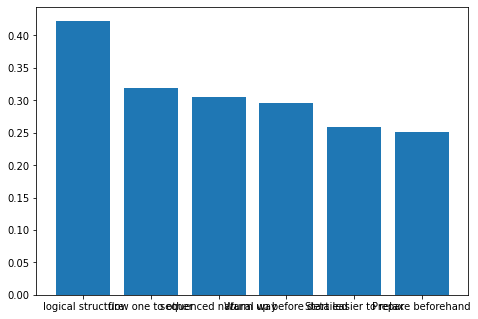

Mean similarity : 0.30859510600566864


[0.3305159679480961, 0.2423979938030243, 0.30859510600566864]
Predicted class :  4
------------------------------------------------------
----------Sentence similarity for :  questions have a logical flow
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: easy direct 	 similarity: 0.6051760911941528
label: easy understand 	 similarity: 0.5956115126609802
label: easy straightforward 	 similarity: 0.5328835248947144
label: clear 	 similarity: 0.5318057537078857
label: succinct 	 similarity: 0.4856983423233032
label: short 	 similarity: 0.1842961311340332
label: Avoid too long 	 similarity: 0.08078145980834961


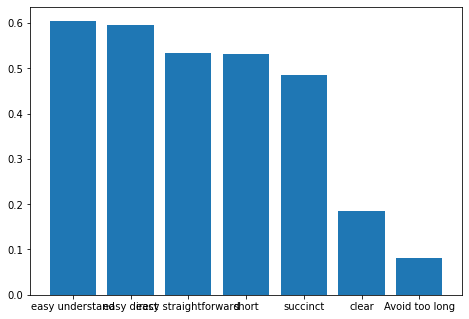

Mean similarity : 0.43089325938905987


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: Do not ask leading 	 similarity: 0.1946108192205429
label: Don't ask directly 	 similarity: 0.18962398171424866
label: Do not ask closed 	 similarity: 0.18319593369960785
label: open ended 	 similarity: 0.155120849609375
label: Avoid suggest answer you want 	 similarity: 0.11332828551530838
label: Do not ask yes/no 	 similarity: 0.0620887316763401


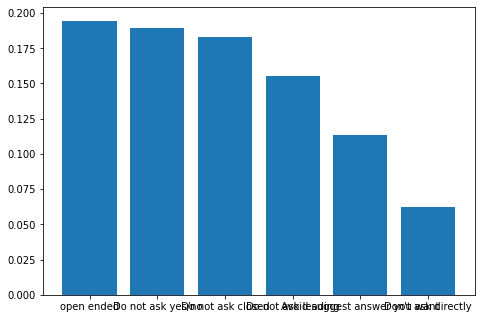

Mean similarity : 0.14966143357257047


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: logical structure 	 similarity: 0.7144714593887329
label: Start easier to relax 	 similarity: 0.3677491545677185
label: sequenced natural way 	 similarity: 0.34551841020584106
label: flow one to other 	 similarity: 0.2951914668083191
label: Warm up before detailed 	 similarity: 0.29153499007225037
label: Prepare beforehand 	 similarity: 0.23784461617469788


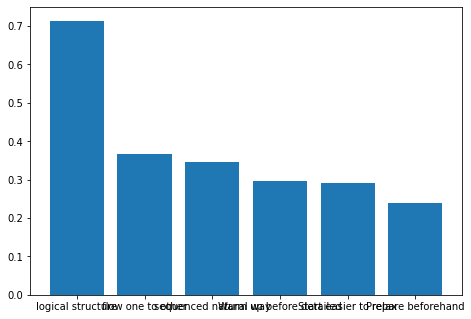

Mean similarity : 0.37538501620292664


[0.43089325938905987, 0.14966143357257047, 0.37538501620292664]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  questions are followed up by apropriate follow up questions
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: succinct 	 similarity: 0.152955561876297
label: clear 	 similarity: 0.10316088050603867
label: Avoid too long 	 similarity: 0.09882790595293045
label: easy direct 	 similarity: 0.08966555446386337
label: easy understand 	 similarity: 0.08520388603210449
label: short 	 similarity: 0.04360242560505867
label: easy straightforward 	 similarity: 0.020214321091771126


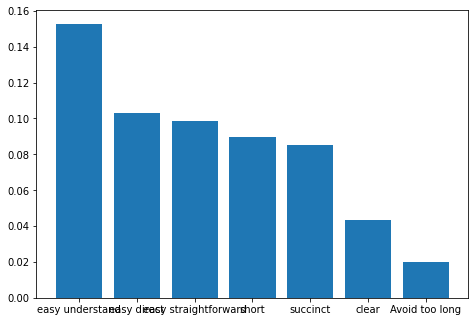

Mean similarity : 0.08480436221829482


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: Avoid suggest answer you want 	 similarity: 0.28482311964035034
label: Don't ask directly 	 similarity: 0.27720388770103455
label: open ended 	 similarity: 0.16582649946212769
label: Do not ask closed 	 similarity: 0.16237668693065643
label: Do not ask yes/no 	 similarity: 0.14362461864948273
label: Do not ask leading 	 similarity: 0.13512352108955383


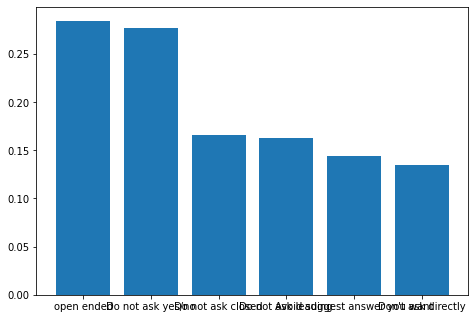

Mean similarity : 0.19482972224553427


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: Prepare beforehand 	 similarity: 0.4461742341518402
label: Warm up before detailed 	 similarity: 0.34180015325546265
label: sequenced natural way 	 similarity: 0.26198920607566833
label: flow one to other 	 similarity: 0.2579571008682251
label: logical structure 	 similarity: 0.1778418868780136
label: Start easier to relax 	 similarity: 0.16352932155132294


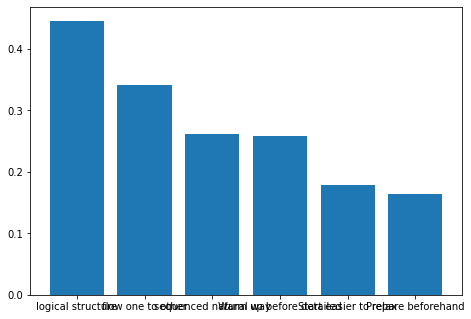

Mean similarity : 0.2748819837967555


[0.08480436221829482, 0.19482972224553427, 0.2748819837967555]
Predicted class :  4
------------------------------------------------------
----------Sentence similarity for :  questions are brief and easy to understand
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: easy straightforward 	 similarity: 0.773331344127655
label: easy understand 	 similarity: 0.7590068578720093
label: easy direct 	 similarity: 0.6342107057571411
label: succinct 	 similarity: 0.5687748789787292
label: short 	 similarity: 0.5665718913078308
label: clear 	 similarity: 0.4344612658023834
label: Avoid too long 	 similarity: 0.20800313353538513


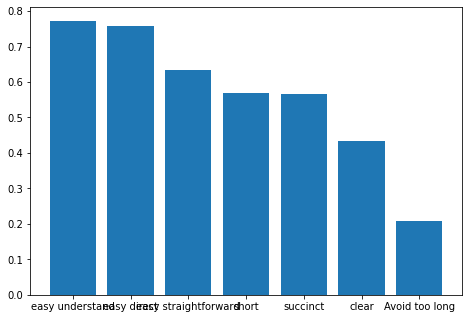

Mean similarity : 0.5634800110544477


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: Do not ask leading 	 similarity: 0.25441691279411316
label: Do not ask closed 	 similarity: 0.22169482707977295
label: open ended 	 similarity: 0.18783344328403473
label: Avoid suggest answer you want 	 similarity: 0.17104610800743103
label: Do not ask yes/no 	 similarity: 0.14123602211475372
label: Don't ask directly 	 similarity: 0.13568177819252014


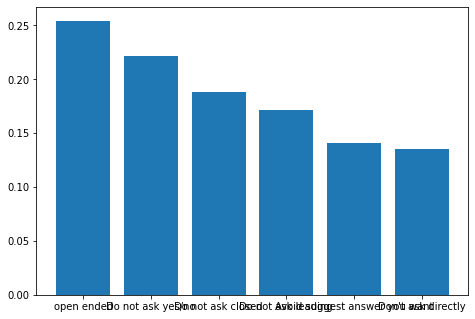

Mean similarity : 0.18531818191210428


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: Start easier to relax 	 similarity: 0.516423225402832
label: logical structure 	 similarity: 0.311419814825058
label: Warm up before detailed 	 similarity: 0.22864916920661926
label: flow one to other 	 similarity: 0.16083262860774994
label: sequenced natural way 	 similarity: 0.13828566670417786
label: Prepare beforehand 	 similarity: -0.00013722479343414307


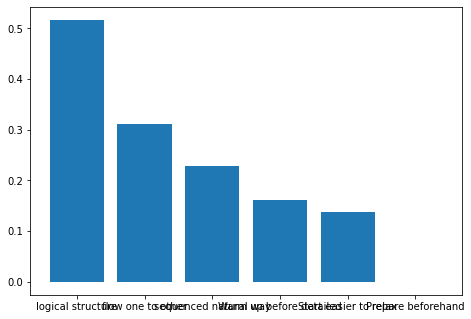

Mean similarity : 0.2259122133255005


[0.5634800110544477, 0.18531818191210428, 0.2259122133255005]
Predicted class :  1
------------------------------------------------------


In [284]:
predictions = cosineSimilarity(sentence_net, 0.4)

              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.38      0.42      0.37         6
weighted avg       0.58      0.50      0.51         6



/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classif

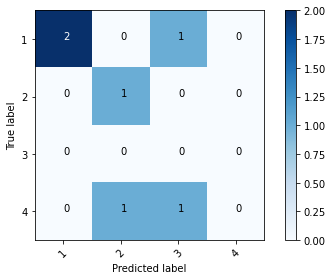

In [285]:
evaluation(predictions, class_labels)

# Interview Question

In [279]:
label1 = ['easy understand','easy direct','easy straightforward','short','succinct','clear','Avoid too long']
label2 = ['open ended','Do not ask yes/no','Do not ask closed','Do not ask leading','Avoid suggest answer you want',"Don't ask directly"]
label3 = ['logical structure','flow one to other','sequenced natural way','Warm up before detailed','Start easier to relax','Prepare beforehand']
labels = [label1, label2, label3]

sentences = {
    'questions are easily understandable':1,
    'questions are not closed ':2,
    'questions are open to interpretation':2,
    'questions have a logical flow':3,
    'questions are followed up by apropriate follow up questions':3,
    'questions are brief and easy to understand':1
}

In [280]:
labels = [label1, label2, label3]
class_labels = []
for key, value in sentences.items():
    class_labels.append(value)

In [281]:
sentence_net = BERTencoding(sentences,labels)

/opt/homebrew/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


----------Sentence similarity for :  questions are easily understandable
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: easy understand 	 similarity: 0.6703381538391113
label: easy direct 	 similarity: 0.6420934200286865
label: easy straightforward 	 similarity: 0.5611382126808167
label: clear 	 similarity: 0.4958990216255188
label: succinct 	 similarity: 0.45353469252586365
label: short 	 similarity: 0.18743547797203064
label: Avoid too long 	 similarity: 0.04380325227975845


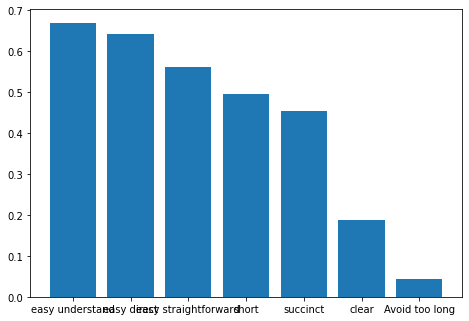

Mean similarity : 0.436320318707398


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: open ended 	 similarity: 0.17659004032611847
label: Do not ask closed 	 similarity: 0.10489607602357864
label: Don't ask directly 	 similarity: 0.09543244540691376
label: Do not ask leading 	 similarity: 0.08675151318311691
label: Avoid suggest answer you want 	 similarity: 0.04967650771141052
label: Do not ask yes/no 	 similarity: -0.017100602388381958


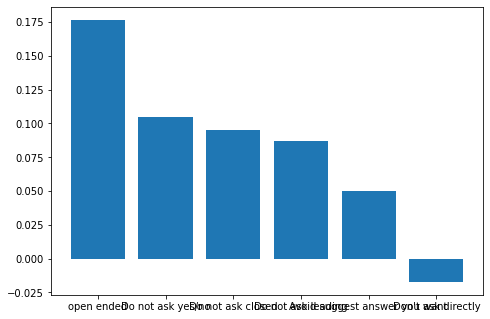

Mean similarity : 0.08270766337712605


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: logical structure 	 similarity: 0.5112177729606628
label: Start easier to relax 	 similarity: 0.42492181062698364
label: Warm up before detailed 	 similarity: 0.3166806995868683
label: sequenced natural way 	 similarity: 0.300115168094635
label: flow one to other 	 similarity: 0.22237913310527802
label: Prepare beforehand 	 similarity: 0.16873590648174286


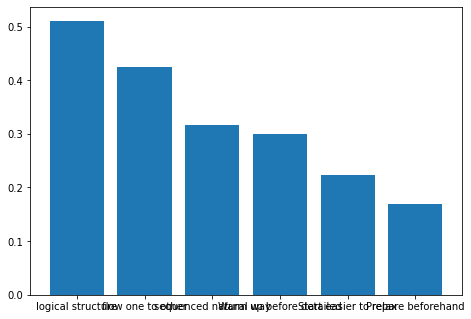

Mean similarity : 0.3240084151426951


[0.436320318707398, 0.08270766337712605, 0.3240084151426951]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  questions are not closed 
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: clear 	 similarity: 0.4633898437023163
label: easy understand 	 similarity: 0.4106239378452301
label: easy direct 	 similarity: 0.4016709327697754
label: easy straightforward 	 similarity: 0.3863743543624878
label: succinct 	 similarity: 0.35172009468078613
label: short 	 similarity: 0.17287582159042358
label: Avoid too long 	 similarity: 0.16260018944740295


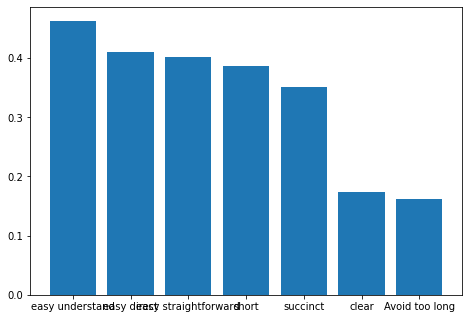

Mean similarity : 0.33560788205691744


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: Do not ask closed 	 similarity: 0.6720290780067444
label: Do not ask leading 	 similarity: 0.4705021381378174
label: Don't ask directly 	 similarity: 0.4613420069217682
label: Do not ask yes/no 	 similarity: 0.32136744260787964
label: Avoid suggest answer you want 	 similarity: 0.30181363224983215
label: open ended 	 similarity: 0.27715542912483215


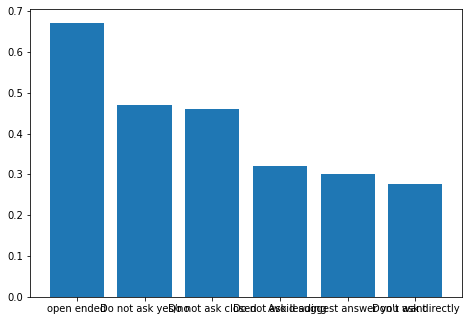

Mean similarity : 0.417368287841479


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: logical structure 	 similarity: 0.3790018558502197
label: flow one to other 	 similarity: 0.3375738263130188
label: Warm up before detailed 	 similarity: 0.26810234785079956
label: Start easier to relax 	 similarity: 0.2493179887533188
label: sequenced natural way 	 similarity: 0.2157585322856903
label: Prepare beforehand 	 similarity: 0.18410031497478485


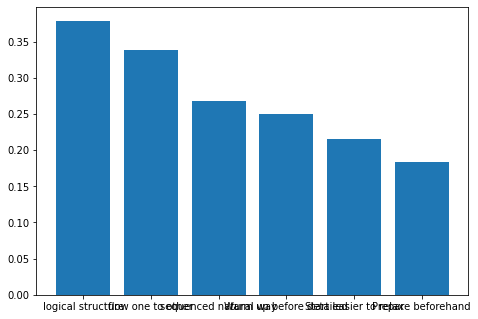

Mean similarity : 0.272309144337972


[0.33560788205691744, 0.417368287841479, 0.272309144337972]
Predicted class :  2
------------------------------------------------------
----------Sentence similarity for :  questions are open to interpretation
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: easy direct 	 similarity: 0.4465622901916504
label: clear 	 similarity: 0.4328763782978058
label: easy understand 	 similarity: 0.431896448135376
label: succinct 	 similarity: 0.4149993062019348
label: easy straightforward 	 similarity: 0.33575162291526794
label: short 	 similarity: 0.14835742115974426
label: Avoid too long 	 similarity: 0.1031683087348938


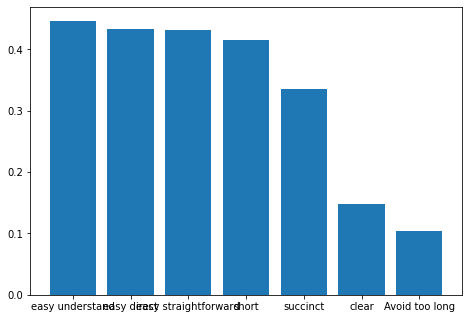

Mean similarity : 0.3305159679480961


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: open ended 	 similarity: 0.34054431319236755
label: Do not ask closed 	 similarity: 0.2575043737888336
label: Avoid suggest answer you want 	 similarity: 0.24897310137748718
label: Don't ask directly 	 similarity: 0.24801908433437347
label: Do not ask leading 	 similarity: 0.2134089469909668
label: Do not ask yes/no 	 similarity: 0.14593814313411713


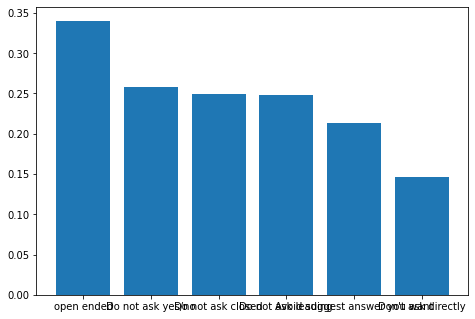

Mean similarity : 0.2423979938030243


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: logical structure 	 similarity: 0.4230130612850189
label: sequenced natural way 	 similarity: 0.31824931502342224
label: flow one to other 	 similarity: 0.3056386411190033
label: Warm up before detailed 	 similarity: 0.2950313091278076
label: Start easier to relax 	 similarity: 0.2592749297618866
label: Prepare beforehand 	 similarity: 0.25036337971687317


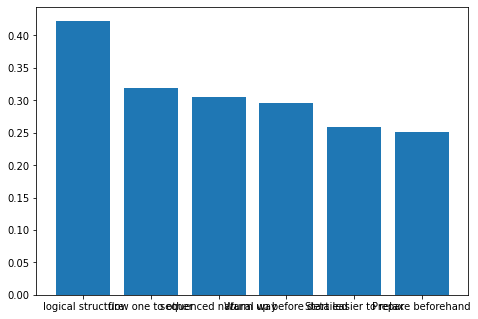

Mean similarity : 0.30859510600566864


[0.3305159679480961, 0.2423979938030243, 0.30859510600566864]
Predicted class :  4
------------------------------------------------------
----------Sentence similarity for :  questions have a logical flow
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: easy direct 	 similarity: 0.6051760911941528
label: easy understand 	 similarity: 0.5956115126609802
label: easy straightforward 	 similarity: 0.5328835248947144
label: clear 	 similarity: 0.5318057537078857
label: succinct 	 similarity: 0.4856983423233032
label: short 	 similarity: 0.1842961311340332
label: Avoid too long 	 similarity: 0.08078145980834961


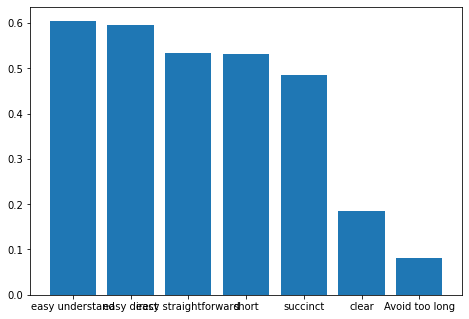

Mean similarity : 0.43089325938905987


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: Do not ask leading 	 similarity: 0.1946108192205429
label: Don't ask directly 	 similarity: 0.18962398171424866
label: Do not ask closed 	 similarity: 0.18319593369960785
label: open ended 	 similarity: 0.155120849609375
label: Avoid suggest answer you want 	 similarity: 0.11332828551530838
label: Do not ask yes/no 	 similarity: 0.0620887316763401


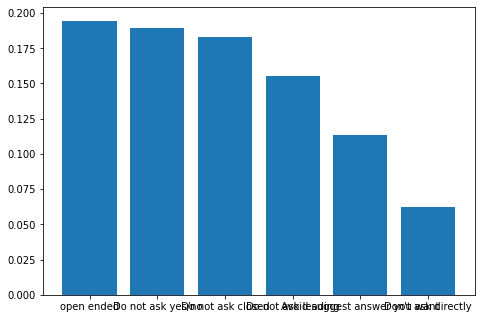

Mean similarity : 0.14966143357257047


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: logical structure 	 similarity: 0.7144714593887329
label: Start easier to relax 	 similarity: 0.3677491545677185
label: sequenced natural way 	 similarity: 0.34551841020584106
label: flow one to other 	 similarity: 0.2951914668083191
label: Warm up before detailed 	 similarity: 0.29153499007225037
label: Prepare beforehand 	 similarity: 0.23784461617469788


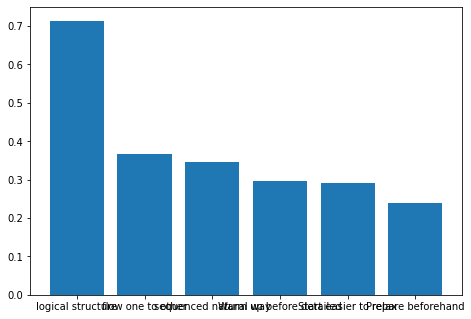

Mean similarity : 0.37538501620292664


[0.43089325938905987, 0.14966143357257047, 0.37538501620292664]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  questions are followed up by apropriate follow up questions
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: succinct 	 similarity: 0.152955561876297
label: clear 	 similarity: 0.10316088050603867
label: Avoid too long 	 similarity: 0.09882790595293045
label: easy direct 	 similarity: 0.08966555446386337
label: easy understand 	 similarity: 0.08520388603210449
label: short 	 similarity: 0.04360242560505867
label: easy straightforward 	 similarity: 0.020214321091771126


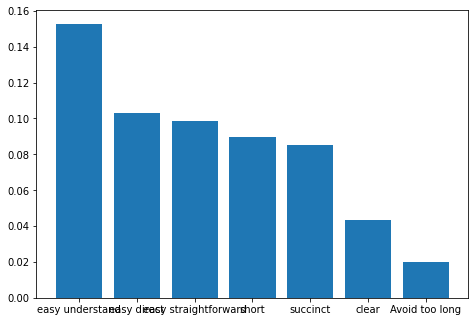

Mean similarity : 0.08480436221829482


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: Avoid suggest answer you want 	 similarity: 0.28482311964035034
label: Don't ask directly 	 similarity: 0.27720388770103455
label: open ended 	 similarity: 0.16582649946212769
label: Do not ask closed 	 similarity: 0.16237668693065643
label: Do not ask yes/no 	 similarity: 0.14362461864948273
label: Do not ask leading 	 similarity: 0.13512352108955383


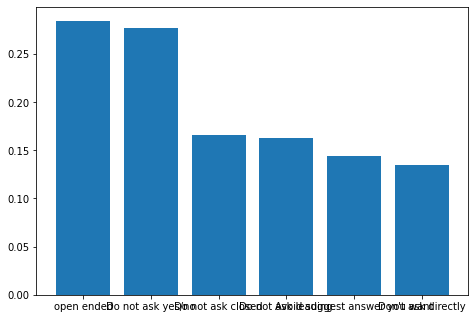

Mean similarity : 0.19482972224553427


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: Prepare beforehand 	 similarity: 0.4461742341518402
label: Warm up before detailed 	 similarity: 0.34180015325546265
label: sequenced natural way 	 similarity: 0.26198920607566833
label: flow one to other 	 similarity: 0.2579571008682251
label: logical structure 	 similarity: 0.1778418868780136
label: Start easier to relax 	 similarity: 0.16352932155132294


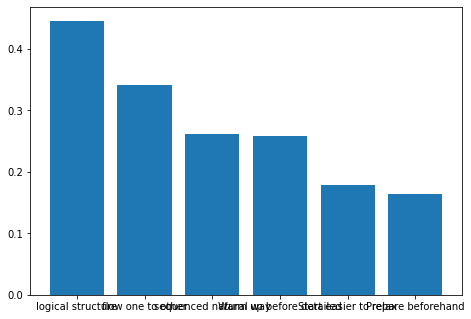

Mean similarity : 0.2748819837967555


[0.08480436221829482, 0.19482972224553427, 0.2748819837967555]
Predicted class :  4
------------------------------------------------------
----------Sentence similarity for :  questions are brief and easy to understand
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: easy straightforward 	 similarity: 0.773331344127655
label: easy understand 	 similarity: 0.7590068578720093
label: easy direct 	 similarity: 0.6342107057571411
label: succinct 	 similarity: 0.5687748789787292
label: short 	 similarity: 0.5665718913078308
label: clear 	 similarity: 0.4344612658023834
label: Avoid too long 	 similarity: 0.20800313353538513


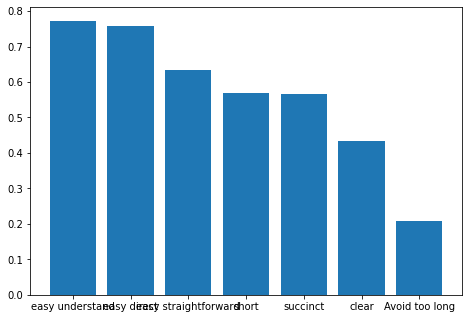

Mean similarity : 0.5634800110544477


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: Do not ask leading 	 similarity: 0.25441691279411316
label: Do not ask closed 	 similarity: 0.22169482707977295
label: open ended 	 similarity: 0.18783344328403473
label: Avoid suggest answer you want 	 similarity: 0.17104610800743103
label: Do not ask yes/no 	 similarity: 0.14123602211475372
label: Don't ask directly 	 similarity: 0.13568177819252014


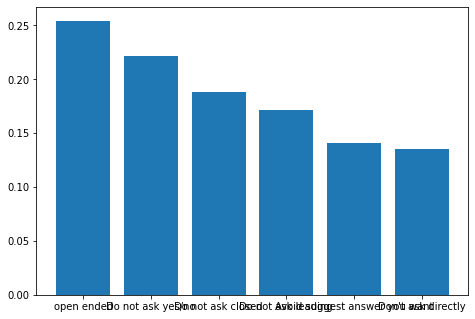

Mean similarity : 0.18531818191210428


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: Start easier to relax 	 similarity: 0.516423225402832
label: logical structure 	 similarity: 0.311419814825058
label: Warm up before detailed 	 similarity: 0.22864916920661926
label: flow one to other 	 similarity: 0.16083262860774994
label: sequenced natural way 	 similarity: 0.13828566670417786
label: Prepare beforehand 	 similarity: -0.00013722479343414307


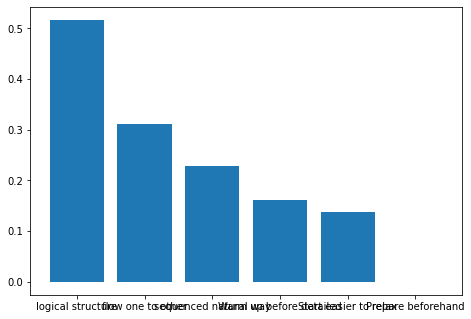

Mean similarity : 0.2259122133255005


[0.5634800110544477, 0.18531818191210428, 0.2259122133255005]
Predicted class :  1
------------------------------------------------------


In [282]:
predictions = cosineSimilarity(sentence_net, 0.4)

              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.38      0.42      0.37         6
weighted avg       0.58      0.50      0.51         6



/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classif

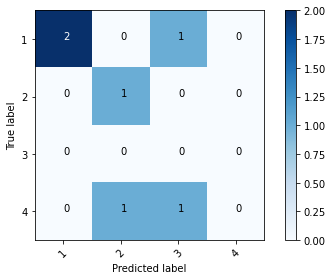

In [283]:
evaluation(predictions, class_labels)